In [ ]:
'''
1.Dataset information
The data set consists of information on 18,000 current bank customers.
It contains their financial information as well as the bank servies they have and the method the bank sends out the offer.
2.File upload steps:
The data is first uploaded using MySQLWorkBench with the corrected headers' names. 
After some data exploration in WorkBench, I then created connection with the JupyterNotebook and upload the data here.
3.Attribute Information:
The dataset comprises of 8 numerical variables and 7 categorical variables. They are defined as belowed:
- 'offer_accepted': used as the class label, indicating whether that particular customer accepts the offer or not. It is the target feature in our prediction model.
- 'customer_id': A sequential number assigned to the customers (this column is hidden and excluded – this unique identifier will not be used directly).
- 'reward': The type of reward program offered for the card.
- 'mailer_type': Letter or postcard.
- 'income_level': Low, Medium, or High.
- 'nr_of_bank_accounts_open': How many non-credit-card accounts are held by the customer.
- 'overdraft_protection': Does the customer have overdraft protection on their checking account(s) (Yes or No).
- 'credit_rating': Low, Medium, or High.
- 'credit_cards_held': The number of credit cards held at the bank.
- 'homes_owned': The number of homes owned by the customer.
- 'household_size': The number of individuals in the family.
- 'own_your_home': Does the customer own their home? (Yes or No).
- 'average_balance': Average account balance (across all accounts over time)
- 'balance_q1','balance_q2','balance_q3','balance_q4': The average balance for each quarter in the last year. 'balance_q4' will not be used and will be dropped from our data.
    '''

# Project classification

## 1. Import libraries

In [1]:
# Import pandas, numpy
import pandas as pd
import numpy as np

# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Import matplotlib for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, accuracy_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# feature importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

pd.set_option('display.max_columns', 500)

## 2. Functions

### 2.1 Creating functions for data exploring 

In [2]:
# Basic exploration information about the dataframe
def basic_information(df):
    df_cols=list(df.columns)
    print("Basic information")
    print("Shape of DF:", df.shape)

    for col in df_cols:
        print("Name: {}".format(df[col].name))
        print("Type: {}".format(df[col].dtype))
        print("Unique values: {}".format(len(df[col].unique())))
        print("NaN values: {}".format(df[col].isna().sum()))
        print("0 values: {}".format(df[col].isin([0]).sum()))
        plt.hist(df[col],bins=20)
        plt.show()
        print("Value counts:\n{}".format(df[col].value_counts()))
        print (" ")
        print("==========================================")
        print(" ")

In [3]:
# Checking null values and 0 values
def gettingzeros(df):
    df_cols=list(df.columns)
    print("Checking Null Values")
    print(" ")
    storage_balance = []

    for col in df_cols:
        print("Name: {}".format(df[col].name))
        print("NaN values: {}".format(df[col].isna().sum()))
        print("0 values: {}".format(df[col].isin([0]).sum()))
        print(" ")

In [4]:
# master function to explore data
def explore_data(df):
    basic_information(df)
    gettingzeros(df)

In [5]:
 # clean nulls in balances
def cleaning_nulls(df):
    df = df[df['balance_q1'] > 0]
    df = df[df['balance_q2'] > 0]
    df = df[df['balance_q3'] > 0]
    return df

In [6]:
# drop dupplicates or drop a list you want
def dropping(df,drop_list=None):
    df.drop_duplicates()
    if drop_list != None:
        df.drop(drop_list=None, axis = 1, inplace = True)
    return df

In [7]:
# cluster values that are not frequent in one category
def clean_household_size(x):
    if x > 5:
        return 6
    else:
        return x

def clean_cc_held(x):
    if x > 2:
        return 2
    else:
        return x

def clustering_columns(df):
    df.household_size = list(map(clean_household_size, df.household_size))
    df.credit_cards_held = list(map(clean_cc_held, df.credit_cards_held))
    df.nr_of_bank_accounts_open = list(map(lambda x: 1 if x == 1 else 2,df.nr_of_bank_accounts_open))
    df.nr_of_homes_owned = list(map(lambda x: 1 if x == 1 else 2,df.nr_of_homes_owned))
    return df

In [8]:
# master cleaning function that calls the functions above
def cleaning_columns(df, drop_list=None):
    df = cleaning_nulls(df)
    df = dropping(df,drop_list=None)
    df = clustering_columns(df)
    return df

### 2.2 Creating functions for data categories

In [9]:
# data separation in types: categorical,  numerical discrete and continuous
def data_sep(df,types, target=None):
    num_discrete = []
    num_continuous = []
    num = df.select_dtypes(include = np.number)
    for i in num.columns:
        if 'balance' in i:
            num_continuous.append(i)
        else:
            num_discrete.append(i)
    if types == 'numerical':
        return num
    elif types == 'discrete':
        return df[num_discrete]
    elif types == 'continuous':
        return df[num_continuous]
    else:
        cat = df.select_dtypes(include = np.object)
        #cat = cat.drop(target, axis = 1)
        return cat

In [11]:
# plots from different data categories
def plots(df, types):
    import seaborn as sns
    if types == 'correlation matrix':
        corr_matrix=df.corr(method='pearson')
        fig, ax = plt.subplots(figsize=(10, 8))
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True
        ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
        return plt.show()
    elif types == 'describe':
        print(df.describe().T)
        print(" ")
        return df.describe()
        for i in df.columns:
            print('Column: ',i)
            if types == 'continuous':
                sns.distplot(df[i])
            elif types == 'categorical' or types == 'discrete':
                sns.countplot(x=i,data=df)
            elif types == 'boxplot':
                sns.boxplot(x=i, data=df)
                plt.show()
                print('====================')

In [12]:
# master plot  with all the plots we want to plot
def plot_master():
    print("** PLOTTING NUM DESCRIBE **")
    plots(df,'describe')

    print("** PLOTING CATEGORICAL VARIABLES **")
    plots(cat,'categorical')
    print(" ")

    print("** PLOTING CONTINUOUS VARIABLES **")
    plots(num_cont, 'continuous')
    print(" ")

    print("** PLOTTING DISCRETE VARIABLES **")
    plots(num_disc,'discrete')
    print(" ")

    print("** PLOTTING CORRELATION MATRIX **")
    plots(num,'correlation matrix')

In [13]:
# function to see the skew in numerical continuous
def skew_df(df):
    from scipy.stats import skew
    
    cols=list(df.columns)
    
    for col in cols:
        sk=df[col].skew()
        print("the skew of {} is: {}".format(col,sk))

In [14]:
# getting VIF scores
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores['independent_features'] = num.columns
    VIF_Scores['vif_score'] = [variance_inflation_factor(num.values,i) for i in range(num.shape[1])]
    return VIF_Scores

In [15]:
# checking categorical dependency with chi-test
def chi_test(df,x,y):
    from scipy.stats import chi2_contingency
    from scipy.stats import chi2
    # contingency table
    table = pd.crosstab(df[x], df[y])
    print(table)
    stat, p, dof, expected = chi2_contingency(table)
    print('dof=%d' % dof)
    print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('!!!!! DEPENDENT (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('==========================================================')

In [16]:
# apply chi-test for all categoricals
def applying_chi_test(cat):
    for i in cat.columns:
        for v in cat.columns:
            if i != v:
                print('==========================================================')
                print('RELATIONSHIP {} and {}'.format(i.upper(),v.upper()))
                chi_test(cat,i,v)

### 2.3 Creating functions for data encoding

In [17]:
# convert categrical ordinals 
def ordinals_conversor(df):
    df2 = df.copy()
    for col in df2:
        if len(df2[col].unique()) > 2:
            df2[col]= list(map(lambda x: 2 if x == 'High' else (0 if x == 'Low' else 1),df2[col]))
        else:
            df2[col]= list(map(lambda x: 1 if x =='Yes' else 0,df2[col]))
    return df2

In [18]:
# master conversor. Encodes all categoricals
def converting_categoricals(cat):
    df = cat.copy()
    df = ordinals_conversor(df)
    df2 = pd.get_dummies(df)
    return df2

### 2.4 Creating functions for prediction

In [19]:
# spliting data in features and targte
def split_xy(cat,num):
    #Concatenating numericals and categoricals 
    df = pd.concat([cat,num],axis=1)
    y = pd.DataFrame(df['offer_accepted'])
    X = df.drop(['offer_accepted'],axis=1)
    #returning X (features) and y (target) dataframes
    return X,y


In [20]:
# splitting data into train and test
def splitting_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [21]:
# scalers functions
def scalers(X_train, X_test, scaler):
    if scaler == 'normalizer':
        transformer = Normalizer().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test) 
    elif scaler == 'standard':
        transformer = StandardScaler().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)
    elif scaler == 'minmax':
        transformer = MinMaxScaler().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)
    elif scaler == 'power':
        transformer = PowerTransformer().fit(X_train)
        X_train_t = transformer.transform(X_train)
        X_test_t = transformer.transform(X_test)

    X_train_t = pd.DataFrame(X_train_t, columns = X_train.columns)
    X_test_t = pd.DataFrame(X_test_t, columns = X_test.columns)

    return X_train_t, X_test_t

In [22]:
# sampling functions
def samplings_type(X_train, y_train, samp):
    if samp =='downsampling':
        s = RandomUnderSampler()
    elif samp == 'upsampling':
        s = RandomOverSampler()
    elif  samp == 'tomeklinks':
        s = TomekLinks('majority')

    X_s, y_s = s.fit_sample(X_train, y_train)
    X_train_s = pd.DataFrame(X_s, columns = X_train.columns)
    y_train_s = pd.DataFrame(y_s, columns = ['offer_accepted'])

    return X_train_s, y_train_s

In [23]:
# predict function accuracies and kappas
def fit_predict(X_train, X_test, y_train, y_test, model='logistic', k=4):
    import sys
    from sklearn.metrics import accuracy_score, precision_score
    if ( model == 'logistic' ):
        classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train, y_train)
    elif ( model == 'decision_tree' ):
        classification = DecisionTreeClassifier().fit(X_train, y_train)
    elif ( model == 'k-nn'):
          classification = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    else:
        print('Incorrect input model')
        sys.exit()

    y_train_pred = classification.predict(X_train)
    y_test_pred  = classification.predict(X_test)

    accuracy_train = round(accuracy_score(y_train, y_train_pred),2)
    accuracy_test  = round(accuracy_score(y_test, y_test_pred),2)

    kappa_train = round(cohen_kappa_score(y_train, y_train_pred),2)
    kappa_test  = round(cohen_kappa_score(y_test, y_test_pred),2)

    return accuracy_train, accuracy_test, kappa_train, kappa_test

In [24]:
# function that returns y_test_predict
def y_predict(X_train, X_test, y_train, y_test, model='logistic', k=4):
    import sys

    if ( model == 'logistic' ):
        classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train, y_train)
        #classification.to_pickle('')
    elif ( model == 'decision_tree' ):
        classification = DecisionTreeClassifier().fit(X_train, y_train)
    elif ( model == 'k-nn' ):
          classification = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    else:
        print('Incorrect input model')
        sys.exit()

    y_train_pred = classification.predict(X_train)
    y_test_pred  = classification.predict(X_test)
    return y_test_pred

In [25]:
# applying scaling, sampling and predicting
def get_scores(X,y, model,k=4):
    from sklearn.metrics import precision_score, recall_score
    X_train, X_test, y_train, y_test = splitting_data(X,y)

    my_dict =  {'scaler': [], 'sampling': [], 'precision':[],'recall':[],'accuracy': [], 'kappa': [], 'set': []}

    for scaler in ['normalizer','standard','minmax','power']:
        for sampling in ['downsampling','upsampling','tomeklinks']:

            X_train_t, X_test_t = scalers(X_train, X_test, scaler)
            X_train_s, y_train_s = samplings_type(X_train_t, y_train, sampling)

            accuracy_train, accuracy_test, kappa_train, kappa_test = fit_predict(X_train_s, X_test_t, y_train_s, y_test, model)
            y_pred = y_predict(X_train_s, X_test_t, y_train_s, y_test, model,k=4)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)

            my_dict['scaler'].append(scaler)
            my_dict['sampling'].append(sampling)
            my_dict['precision'].append(precision)
            my_dict['recall'].append(recall)
            my_dict['accuracy'].append(accuracy_train)
            my_dict['kappa'].append(kappa_train)
            my_dict['set'].append('train')

            my_dict['scaler'].append(scaler)
            my_dict['sampling'].append(sampling)
            my_dict['precision'].append(precision)
            my_dict['recall'].append(recall)
            my_dict['accuracy'].append(accuracy_test)
            my_dict['kappa'].append(kappa_test)
            my_dict['set'].append('test')

    results = pd.DataFrame(my_dict)
    return results

In [26]:
# confusion matrix information
def confusion_matrix_info(X,y,scaler,samp,model):
    X_train, X_test, y_train, y_test = splitting_data(X,y)
    X_train_t, X_test_t = scalers(X_train, X_test,scaler)
    X_train_s, y_train_s = samplings_type(X_train_t, y_train, samp)

    if ( model == 'logistic' ):
        classification = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train_s, y_train_s)
    elif ( model == 'decision_tree' ):
        classification = DecisionTreeClassifier().fit(X_train_s, y_train_s)
    elif ( model == 'k-nn' ):
        classification = KNeighborsClassifier(n_neighbors=4).fit(X_train_s, y_train_s)

        y_test_pred = classification.predict(X_test_t)
        print('\033[1m'+"The accuracy score in the TEST set is {}".format(round(accuracy_score(y_test,y_test_pred),2)))
        print(" ")
        print('\033[1m'+"The y test value counts are"+'\033[0m'+ "\n {}".format(round(y_test.value_counts(),2)))
        print(" ")
        print('\033[1m'+"Confusion matrix y_test,predictions"+'\033[0m')
        print(confusion_matrix(y_test, y_test_pred))
        print(" ")
        print('\033[1m'+"Confusion matrix X_test_t,y_test"+'\033[0m')
        return plot_confusion_matrix(classification, X_test_t, y_test)

In [27]:
# feature importance function
def feature_importance(X,y,model):
    # define and fit the model
    # get importance
    if model == 'logistic':
        model = LogisticRegression().fit(X,y)
        importance = model.coef_[0]
    elif model ==  'decision_tree':
        model = DecisionTreeRegressor().fit(X,y)
        importance = model.feature_importances_

    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        pyplot.bar([x for x in range(len(importance))], importance)
        pyplot.show()

### 2.5 Master function for improving model

In [45]:
# prepare new dataframe with instructions given in dict_of_steps to process it again
def preprocess(df, dict_of_steps, nombre = None):
    df2 = df.copy()
    for step in list(dict_of_steps.keys()):
        if ( step == 'drop_outliers' and dict_of_steps['drop_outliers'] == 'Yes'):
            iqr = np.percentile(df2['average_balance'],75) - np.percentile(df2['average_balance'],25)
            upper_limit = np.percentile(df2['average_balance'],75) + 1.5*iqr
            df2 = df2[(df2['average_balance']<upper_limit)]
        if ( step == 'drop_cols' and len(dict_of_steps['drop_cols']) != 0):
            df2.drop(columns=dict_of_steps['drop_cols'], axis=1, inplace= True)
        if ( step == 'outliers' and dict_of_steps['outliers'] == 'Yes'):
            iqr = np.percentile(df2['average_balance'],75) - np.percentile(df2['average_balance'],25)
            upper_limit = np.percentile(df2['average_balance'],75) + 1.5*iqr
            df2 = df2[(df2['average_balance']>upper_limit)]

        if (nombre != None):
            file_name = '/content/drive/MyDrive' + nombre
            df2.to_csv(file_name, encoding='utf-8', index=False)

    return df2

In [29]:
# master function that split features and target when we process again the dataframe
def master_xy(df):
    num = data_sep(df,'numerical')
    cat = data_sep(df,'cat','offer_accepted')
    cat = converting_categoricals(cat)
    X,y = split_xy(cat,num)

    return X,y

# master function that shows the confusion matrix and metrics(accuracy, recall and kappa) 
# when we process again the dataframe
def master_scores_confusion_matrix(df,model,scaler,samp):
    X,y = master_xy(df)

    print(" ")
    print('\033[1m'+"Confusion Matrix info"+'\033[0m')
    confusion_matrix_info(X,y,scaler,samp,model)
    plt.show()

    print('\033[1m'+"SCORES"+'\033[0m')
    scores = get_scores(X,y,model)
    return scores

# master functiono to check dependency: chi tesst in categoricals,
# skew in numericals and VIF in numericals.
# Feature importance in features
def master_chi_skew_vif(df):
    num = data_sep(df,'numerical')
    cat = data_sep(df,'cat','offer_accepted')
    cat = cat.drop('offer_accepted',axis=1)
    print('\033[1m'+"CHI TEST"+'\033[0m')
    print(" ")
    applying_chi_test(cat)

    print('\033[1m'+"SKEW TEST"+'\033[0m')
    print(" ")
    skew_df(num)

    print('\033[1m'+"VIF TEST"+'\033[0m')
    print(" ")
    vif_scores(num)

    print('\033[1m'+"FEATURE IMPORTANCE"+'\033[0m')
    print(" ")
    X,y = master_xy(df)
    feature_importance(X,y,model)
    return X

## 3. Connecting to SQL

In [30]:
# Import for connection SQL
import pymysql
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [31]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)
df = pd.read_sql_query('SELECT * FROM credit_card_classification.credit_card_data', engine)
df.head()

,customer_id,offer_accepted,reward,mailer_type,income_level,nr_of_bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,nr_of_homes_owned,household_size,own_your_home,average_balance,balance_q1,balance_q2,balance_q3
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0


In [47]:
df.columns

Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'nr_of_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'credit_cards_held', 'nr_of_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'balance_q1', 'balance_q2',
       'balance_q3'],
      dtype='object')

In [32]:
#dropping customer_id, not needed
df = df.drop(['customer_id'], axis = 1)

In [33]:
#dropping na's
df.dropna(inplace= True)

In [34]:
# Check dependency in categoricals and numericals new DF
master_chi_skew_vif(df)

CHI TEST
 
RELATIONSHIP REWARD and MAILER_TYPE
mailer_type  Letter  Postcard
reward                       
Air Miles      2951      3110
Cash Back      2967      3032
Points         2935      3005
dof=2
[[2981.00183333 3079.99816667]
 [2950.50816667 3048.49183333]
 [2921.49       3018.51      ]]
probability=0.950, critical=5.991, stat=0.899
Independent (fail to reject H0)
significance=0.050, p=0.638
Independent (fail to reject H0)
RELATIONSHIP REWARD and INCOME_LEVEL
income_level  High   Low  Medium
reward                          
Air Miles     1494  1538    3029
Cash Back     1538  1467    2994
Points        1494  1456    2990
dof=4
[[1524.00477778 1502.11783333 3034.87738889]
 [1508.41522222 1486.75216667 3003.83261111]
 [1493.58       1472.13       2974.29      ]]
probability=0.950, critical=9.488, stat=2.594
Independent (fail to reject H0)
significance=0.050, p=0.628
Independent (fail to reject H0)
RELATIONSHIP REWARD and OVERDRAFT_PROTECTION
overdraft_protection    No  Yes
reward

Yes                    884   881     913
dof=2
[[5167.77011111 5070.73077778 5083.49911111]
 [ 903.22988889  886.26922222  888.50088889]]
probability=0.950, critical=5.991, stat=1.311
Independent (fail to reject H0)
significance=0.050, p=0.519
Independent (fail to reject H0)
RELATIONSHIP OVERDRAFT_PROTECTION and OWN_YOUR_HOME
own_your_home           No   Yes
overdraft_protection            
No                    5426  9896
Yes                    919  1759
dof=1
[[5401.005 9920.995]
 [ 943.995 1734.005]]
probability=0.950, critical=3.841, stat=1.153
Independent (fail to reject H0)
significance=0.050, p=0.283
Independent (fail to reject H0)
RELATIONSHIP CREDIT_RATING and REWARD
reward         Air Miles  Cash Back  Points
credit_rating                              
High                2080       2013    1978
Low                 1995       2006    1956
Medium              1986       1980    2006
dof=4
[[2044.24061111 2023.32938889 2003.43      ]
 [2005.85427778 1985.33572222 1965.81      ]

NameError: name 'num' is not defined

## 4. Data Exploration

### 4.1 Applying cleaner and basic information

Basic information
Shape of DF: (18000, 15)
Name: offer_accepted
Type: object
Unique values: 2
NaN values: 0
0 values: 0


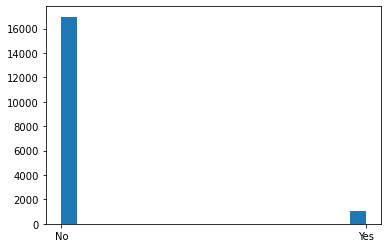

Value counts:
No     16977
Yes     1023
Name: offer_accepted, dtype: int64
 
 
Name: reward
Type: object
Unique values: 3
NaN values: 0
0 values: 0


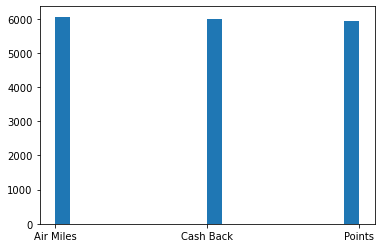

Value counts:
Air Miles    6061
Cash Back    5999
Points       5940
Name: reward, dtype: int64
 
 
Name: mailer_type
Type: object
Unique values: 2
NaN values: 0
0 values: 0


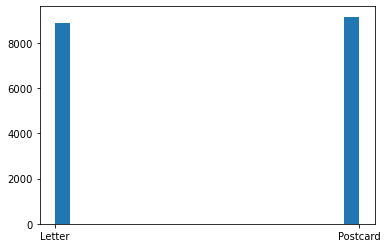

Value counts:
Postcard    9147
Letter      8853
Name: mailer_type, dtype: int64
 
 
Name: income_level
Type: object
Unique values: 3
NaN values: 0
0 values: 0


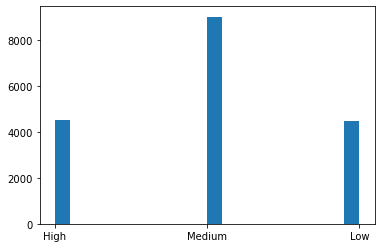

Value counts:
Medium    9013
High      4526
Low       4461
Name: income_level, dtype: int64
 
 
Name: nr_of_bank_accounts_open
Type: int64
Unique values: 3
NaN values: 0
0 values: 0


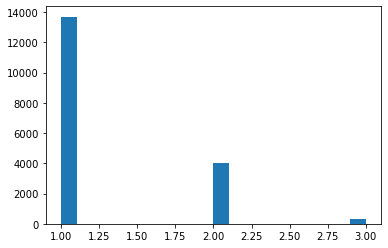

Value counts:
1    13692
2     4012
3      296
Name: nr_of_bank_accounts_open, dtype: int64
 
 
Name: overdraft_protection
Type: object
Unique values: 2
NaN values: 0
0 values: 0


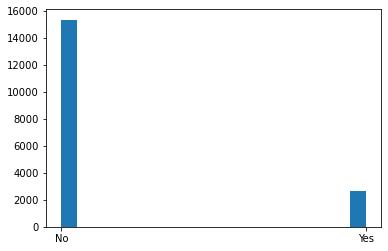

Value counts:
No     15322
Yes     2678
Name: overdraft_protection, dtype: int64
 
 
Name: credit_rating
Type: object
Unique values: 3
NaN values: 0
0 values: 0


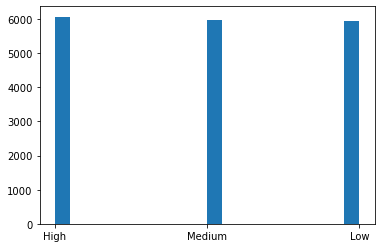

Value counts:
High      6071
Medium    5972
Low       5957
Name: credit_rating, dtype: int64
 
 
Name: credit_cards_held
Type: int64
Unique values: 4
NaN values: 0
0 values: 0


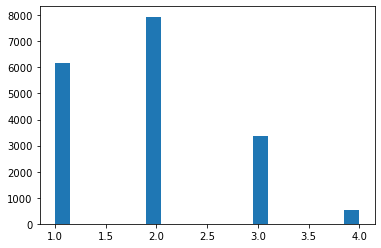

Value counts:
2    7944
1    6154
3    3387
4     515
Name: credit_cards_held, dtype: int64
 
 
Name: nr_of_homes_owned
Type: int64
Unique values: 3
NaN values: 0
0 values: 0


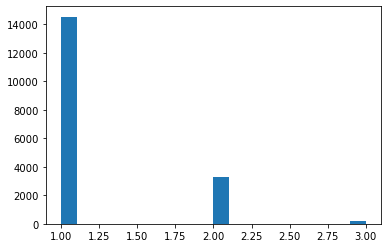

Value counts:
1    14523
2     3292
3      185
Name: nr_of_homes_owned, dtype: int64
 
 
Name: household_size
Type: int64
Unique values: 8
NaN values: 0
0 values: 0


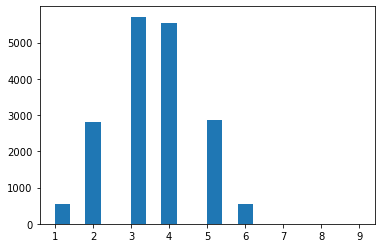

Value counts:
3    5712
4    5543
5    2853
2    2813
1     539
6     538
9       1
8       1
Name: household_size, dtype: int64
 
 
Name: own_your_home
Type: object
Unique values: 2
NaN values: 0
0 values: 0


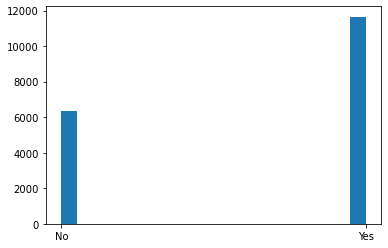

Value counts:
Yes    11655
No      6345
Name: own_your_home, dtype: int64
 
 
Name: average_balance
Type: float64
Unique values: 4729
NaN values: 0
0 values: 24


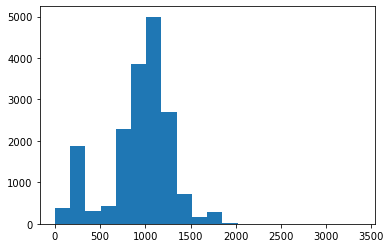

Value counts:
0.00       24
1127.00    17
1033.00    16
1036.00    16
1053.50    16
           ..
596.75      1
379.50      1
1514.00     1
375.75      1
782.50      1
Name: average_balance, Length: 4729, dtype: int64
 
 
Name: balance_q1
Type: float64
Unique values: 2158
NaN values: 0
0 values: 29


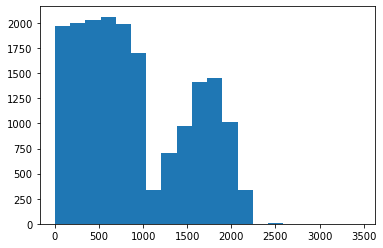

Value counts:
0.0       29
675.0     23
81.0      23
676.0     22
823.0     22
          ..
2002.0     1
1180.0     1
2310.0     1
2185.0     1
1186.0     1
Name: balance_q1, Length: 2158, dtype: int64
 
 
Name: balance_q2
Type: float64
Unique values: 1945
NaN values: 0
0 values: 25


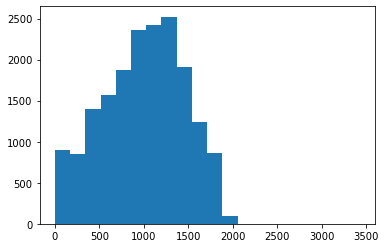

Value counts:
1060.0    30
1197.0    26
0.0       25
1271.0    25
1267.0    24
          ..
257.0      1
2134.0     1
1938.0     1
108.0      1
1898.0     1
Name: balance_q2, Length: 1945, dtype: int64
 
 
Name: balance_q3
Type: float64
Unique values: 2281
NaN values: 0
0 values: 25


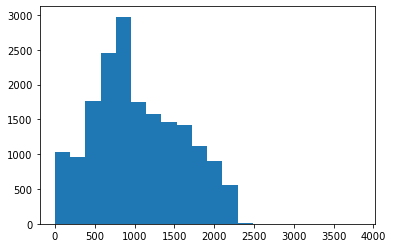

Value counts:
809.0     30
833.0     27
972.0     26
842.0     26
997.0     26
          ..
2039.0     1
2242.0     1
2209.0     1
301.0      1
2030.0     1
Name: balance_q3, Length: 2281, dtype: int64
 
 
Checking Null Values
 
Name: offer_accepted
NaN values: 0
0 values: 0
 
Name: reward
NaN values: 0
0 values: 0
 
Name: mailer_type
NaN values: 0
0 values: 0
 
Name: income_level
NaN values: 0
0 values: 0
 
Name: nr_of_bank_accounts_open
NaN values: 0
0 values: 0
 
Name: overdraft_protection
NaN values: 0
0 values: 0
 
Name: credit_rating
NaN values: 0
0 values: 0
 
Name: credit_cards_held
NaN values: 0
0 values: 0
 
Name: nr_of_homes_owned
NaN values: 0
0 values: 0
 
Name: household_size
NaN values: 0
0 values: 0
 
Name: own_your_home
NaN values: 0
0 values: 0
 
Name: average_balance
NaN values: 0
0 values: 24
 
Name: balance_q1
NaN values: 0
0 values: 29
 
Name: balance_q2
NaN values: 0
0 values: 25
 
Name: balance_q3
NaN values: 0
0 values: 25
 


,offer_accepted,reward,mailer_type,income_level,nr_of_bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,nr_of_homes_owned,household_size,own_your_home,average_balance,balance_q1,balance_q2,balance_q3
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0


In [35]:
# data exploration
explore_data(df)
df = cleaning_columns(df)
df.head()

### 4.2. Data categories and exploration

#### 4.2.1 Applying functions for data categories

In [36]:
# Numerical Data
num = data_sep(df,'numerical')
num.head()


,nr_of_bank_accounts_open,credit_cards_held,nr_of_homes_owned,household_size,average_balance,balance_q1,balance_q2,balance_q3
0,1,2,1,4,1160.75,1669.0,877.0,1095.0
1,1,2,2,5,147.25,39.0,106.0,78.0
2,2,2,1,2,276.50,367.0,352.0,145.0
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0


In [37]:
# Discrete data
num_disc = data_sep(df, 'discrete')
num_disc.head()

,nr_of_bank_accounts_open,credit_cards_held,nr_of_homes_owned,household_size
0,1,2,1,4
1,1,2,2,5
2,2,2,1,2
3,2,1,1,4
4,1,2,1,6


In [38]:
# Continuous data
num_cont = data_sep(df, 'continuous')
num_cont.head()

,average_balance,balance_q1,balance_q2,balance_q3
0,1160.75,1669.0,877.0,1095.0
1,147.25,39.0,106.0,78.0
2,276.50,367.0,352.0,145.0
3,1219.00,1578.0,1760.0,1119.0
4,1211.00,2140.0,1357.0,982.0


In [39]:
# Categorical data
cat = data_sep(df,'cat','offer_accepted')
cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


##### 4.2.2 Data categories exploration

** PLOTTING NUM DESCRIBE **
                            count         mean         std    min     25%  \
nr_of_bank_accounts_open  17969.0     1.239357    0.426703   1.00    1.00   
credit_cards_held         17969.0     1.658078    0.474367   1.00    1.00   
nr_of_homes_owned         17969.0     1.193333    0.394923   1.00    1.00   
household_size            17969.0     3.498803    1.113500   1.00    3.00   
average_balance           17969.0   940.757875  350.093745  48.25  787.75   
balance_q1                17969.0   910.785408  619.962699   1.00  393.00   
balance_q2                17969.0   999.604430  457.254096   1.00  663.00   
balance_q3                17969.0  1042.295286  553.310560   1.00  633.00   

                             50%      75%      max  
nr_of_bank_accounts_open     1.0     1.00     2.00  
credit_cards_held            2.0     2.00     2.00  
nr_of_homes_owned            1.0     1.00     2.00  
household_size               3.0     4.00     6.00  
average_balan

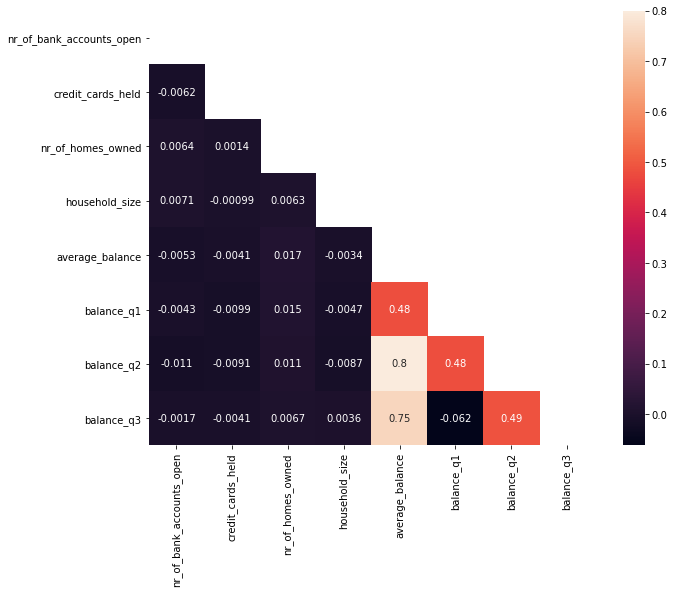

In [40]:
plot_master()

The columns with high correlation is 'average_balance' and other quarterly balances as expected. Other than that there is no multicollearity between numerical variables.

In [41]:
# Looking at dependency between categoricals with Chi-test 
applying_chi_test(cat)

RELATIONSHIP OFFER_ACCEPTED and REWARD
reward          Air Miles  Cash Back  Points
offer_accepted                              
No                   5583       5787    5578
Yes                   463        206     352
dof=2
[[5702.46580221 5652.4772664  5593.05693138]
 [ 343.53419779  340.5227336   336.94306862]]
probability=0.950, critical=5.991, stat=101.105
Dependent (reject H0)
significance=0.050, p=0.000
!!!!! DEPENDENT (reject H0)
RELATIONSHIP OFFER_ACCEPTED and MAILER_TYPE
mailer_type     Letter  Postcard
offer_accepted                  
No                8540      8408
Yes                300       721
dof=1
[[8337.71050142 8610.28949858]
 [ 502.28949858  518.71050142]]
probability=0.950, critical=3.841, stat=169.180
Dependent (reject H0)
significance=0.050, p=0.000
!!!!! DEPENDENT (reject H0)
RELATIONSHIP OFFER_ACCEPTED and INCOME_LEVEL
income_level    High   Low  Medium
offer_accepted                    
No              4352  4067    8529
Yes              165   387     469
do

Medium          8529  469
dof=2
[[4260.34370304  256.65629696]
 [4200.92336802  253.07663198]
 [8486.73292893  511.26707107]]
probability=0.950, critical=5.991, stat=113.548
Dependent (reject H0)
significance=0.050, p=0.000
!!!!! DEPENDENT (reject H0)
RELATIONSHIP INCOME_LEVEL and REWARD
reward        Air Miles  Cash Back  Points
income_level                              
High               1491       1534    1492
Low                1532       1466    1456
Medium             3023       2993    2982
dof=4
[[1519.82759196 1506.50459124 1490.6678168 ]
 [1498.63008515 1485.49290445 1469.87701041]
 [3027.54232289 3001.00250431 2969.4551728 ]]
probability=0.950, critical=9.488, stat=2.261
Independent (fail to reject H0)
significance=0.050, p=0.688
Independent (fail to reject H0)
RELATIONSHIP INCOME_LEVEL and MAILER_TYPE
mailer_type   Letter  Postcard
income_level                  
High            2201      2316
Low             2217      2237
Medium          4422      4576
dof=2
[[2222.175969

 [5721.47587512 5908.52412488]]
probability=0.950, critical=3.841, stat=0.317
Independent (fail to reject H0)
significance=0.050, p=0.574
Independent (fail to reject H0)
RELATIONSHIP OWN_YOUR_HOME and INCOME_LEVEL
income_level   High   Low  Medium
own_your_home                    
No             1634  1551    3154
Yes            2883  2903    5844
dof=2
[[1593.481162 1571.256386 3174.262452]
 [2923.518838 2882.743614 5823.737548]]
probability=0.950, critical=5.991, stat=2.195
Independent (fail to reject H0)
significance=0.050, p=0.334
Independent (fail to reject H0)
RELATIONSHIP OWN_YOUR_HOME and OVERDRAFT_PROTECTION
overdraft_protection    No   Yes
own_your_home                   
No                    5421   918
Yes                   9874  1756
dof=1
[[5395.68172965  943.31827035]
 [9899.31827035 1730.68172965]]
probability=0.950, critical=3.841, stat=1.185
Independent (fail to reject H0)
significance=0.050, p=0.276
Independent (fail to reject H0)
RELATIONSHIP OWN_YOUR_HOME and CREDI

In [42]:
# Skewness for numerical variables
skew_df(num_cont)

the skew of average_balance is: -0.5722743460162316
the skew of balance_q1 is: 0.4107547643914719
the skew of balance_q2 is: -0.18305623801164111
the skew of balance_q3 is: 0.28995754500514986


They do not fall in range [-2,2], therefore we do not need to perform log/box-cox tranformation on them.

In [43]:
# VIF scores for numerical variables
vif_scores(num)

,independent_features,vif_score
0,nr_of_bank_accounts_open,7.772057
1,credit_cards_held,9.775468
2,nr_of_homes_owned,8.310816
3,household_size,8.657988
4,average_balance,79.665624
5,balance_q1,8.921909
6,balance_q2,17.575137
7,balance_q3,24.012667


'average_balance' has high VIF score due to the colleration with quarterly balances. Dropping quarterly balances will bring it down dramatically.

## 5. Data encoding

### 5.1 Applying functions for data encoding

In [44]:
# encoding categoricals
cat = converting_categoricals(cat)
cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,0,1,0,2,0,2,0
1,0,1,0,1,0,1,1
2,0,1,0,2,0,1,1
3,0,1,0,1,0,2,0
4,0,1,0,1,0,1,1


In [46]:
cat.reward.value_counts()

1    17969
Name: reward, dtype: int64

## 6. Prediction

### 6.1 Applying functions for prediction

In [622]:
# getting X (features) and Y (target)
X,y = split_xy(cat,num)

In [624]:
# get metrics for every model, scaler and sampling to choose the best one
### CHOOSE metric BETWEEN 'logistic','decision_tree','k-nn'.
metric = 'logistic'
get_scores(X,y,metric)

,scaler,sampling,precision,recall,accuracy,kappa,set
0,normalizer,downsampling,-,-,0.53,0.05,train
1,normalizer,downsampling,0.0653565,0.448276,0.59,0.01,test
2,normalizer,upsampling,-,-,0.51,0.01,train
3,normalizer,upsampling,0.0655885,0.45768,0.58,0.01,test
4,normalizer,tomeklinks,-,-,0.94,0.00,train
5,normalizer,tomeklinks,0,0,0.94,0.00,test
6,standard,downsampling,-,-,0.69,0.39,train
7,standard,downsampling,0.118511,0.708464,0.67,0.11,test
8,standard,upsampling,-,-,0.69,0.38,train
9,standard,upsampling,0.120993,0.733542,0.67,0.12,test


The accuracy score in the TEST set is 0.67
 
The y test value counts are
 offer_accepted
0                 5072
1                  319
dtype: int64
 
Confusion matrix y_test,predictions
[[3380 1692]
 [  87  232]]
 
Confusion matrix X_test_t,y_test


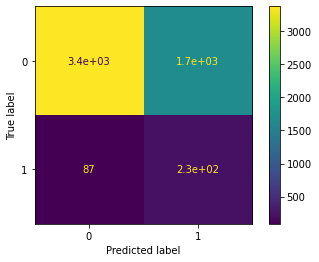

In [625]:
# choosing the best scaler, sampling and model to create the final confusion matrix and y-pred
# possible scalers: normalizer, standard, minmax, power
# possible samp (sampling): upsampling, downsampling, tomeklinks
# possible model: logistic, decision_tree, k-nn
scaler = 'standard'
samp  = 'upsampling'
model = 'logistic'

# confusion matrix information
confusion_matrix_info(X,y,scaler,samp,model)

In [626]:
# splitting data into train and teset
X_train, X_test, y_train, y_test = splitting_data(X,y)

In [627]:
# applying model, scaler, sampling decided before and check the predictions
X_train_t, X_test_t = scalers(X_train, X_test, scaler)
X_train_s, y_train_s = samplings_type(X_train_t, y_train, samp)
y_test = splitting_data(X,y)[3]
y_prediction = y_predict(X_train_s, X_test, y_train_s, y_test, model, k=None)
y_pred = pd.DataFrame(y_prediction).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)
y_pred_test = pd.concat([y_pred,y_test],axis=1,ignore_index=True)
y_pred_test.columns = ['offers_accepted_prediction','offers_accepted']
y_pred_test

,offers_accepted_prediction,offers_accepted
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
5386,0,0
5387,0,0
5388,0,0
5389,0,0


Feature: 0, Score: 0.27352
Feature: 1, Score: -0.62296
Feature: 2, Score: -0.03767
Feature: 3, Score: -0.66864
Feature: 4, Score: 0.28153
Feature: 5, Score: -0.54473
Feature: 6, Score: 0.39424
Feature: 7, Score: -0.23662
Feature: 8, Score: -0.19911
Feature: 9, Score: -0.18800
Feature: 10, Score: -0.97145
Feature: 11, Score: 0.84338
Feature: 12, Score: -0.25904
Feature: 13, Score: -0.20582
Feature: 14, Score: -0.18129
Feature: 15, Score: -0.21233
Feature: 16, Score: -0.25111
Feature: 17, Score: -0.22706
Feature: 18, Score: -0.17165
Feature: 19, Score: -0.00046
Feature: 20, Score: -0.00011
Feature: 21, Score: 0.00008
Feature: 22, Score: 0.00013


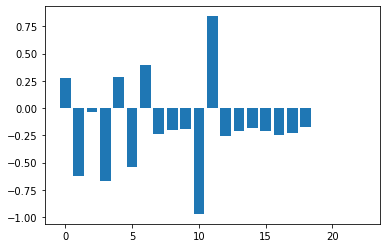

In [628]:
# checking the features importance of our data
model = 'logistic'
feature_importance(X,y,model)

We have seen the model has improved so we continue dropping *the balance columns* and we see another kappa 1% improvement.

We are not able to continue improving the model.

## 4. Improving the model

In [629]:
#### MODIFY my_dict TO TRY creating DIFFERENT DFs 
my_dict = {'drop_outliers': 'No', 'drop_cols': ['household_size','credit_cards_held','average_balance','balance_q1','balance_q2','balance_q3','nr_of_homes_owned'], 'outliers': 'No'}
# include another argument,if you want, to save your new df. E.g.: 'df_with_outliers.csv'
df = preprocess(df,my_dict)

In [632]:
# choose a model, scaler and sampling for testing
# confusion matrix and/or metrics.
# Options you can choose from:
# model:'logistic','decision_tree','k-nn'
# scaler: 'standard','normalizer','minmax','power' (power transform)
# samp: 'upsampling','downsampling','tomeklinks'
model = 'logistic'
scaler = 'standard'
samp  = 'upsampling'

 
Confusion Matrix info
The accuracy score in the TEST set is 0.68
 
The y test value counts are
 offer_accepted
0                 5072
1                  319
dtype: int64
 
Confusion matrix y_test,predictions
[[3436 1636]
 [  92  227]]
 
Confusion matrix X_test_t,y_test


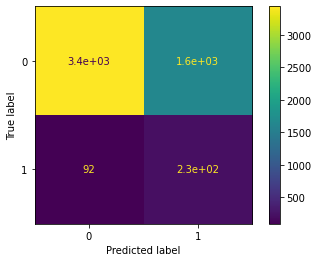

SCORES


,scaler,sampling,precision,recall,accuracy,kappa,set
0,normalizer,downsampling,-,-,0.68,0.36,train
1,normalizer,downsampling,0.115266,0.705329,0.66,0.11,test
2,normalizer,upsampling,-,-,0.69,0.38,train
3,normalizer,upsampling,0.118922,0.705329,0.67,0.11,test
4,normalizer,tomeklinks,-,-,0.94,0.00,train
5,normalizer,tomeklinks,0,0,0.94,0.00,test
6,standard,downsampling,-,-,0.70,0.40,train
7,standard,downsampling,0.123295,0.708464,0.68,0.12,test
8,standard,upsampling,-,-,0.69,0.38,train
9,standard,upsampling,0.118045,0.711599,0.67,0.11,test


In [635]:
# Check metrics and confusion matrix for new DF
master_scores_confusion_matrix(df,model,scaler,samp)

**`Improving the model`**:

Dropping *overdraft_protection, own_your_home and reward_Points* improves the metrics (using logistic, standard,upsampling).
From the test set we can see that Kappa improves 1% with a 12%.
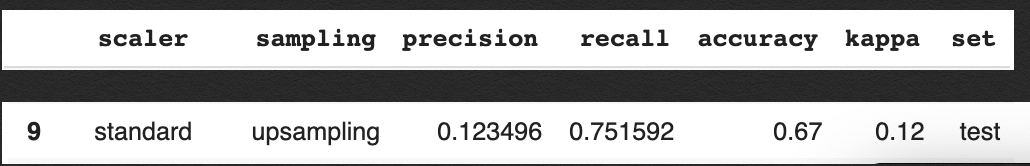